In [1]:
%%time
import numpy as np
import sklearn
import pandas as pd 
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adadelta,Adam,RMSprop
from keras.utils import np_utils

from sklearn.preprocessing import StandardScaler

import sys  #system specific parameters and names
import gc   #garbage collector interface

from scipy.sparse import hstack, csr_matrix

from sklearn.feature_extraction.text import TfidfVectorizer

import category_encoders as ce

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

CPU times: user 6.31 s, sys: 2.08 s, total: 8.39 s
Wall time: 18 s


## Load data

In [2]:
%%time
file_in ='/Users/wailunchung/Documents/GitHub/Capstone_data/index_sec'
import pickle as pickle
with open(file_in, "rb") as fh:
    data2 = pickle.load(fh)


CPU times: user 18.3 s, sys: 15.2 s, total: 33.5 s
Wall time: 39.5 s


In [3]:
%%time
# remove <500
data2 = data2.loc[(data2['file_text_length'] >= 500)]
# get response 
data2['per_change_exceeding'] = np.where(data2['Pct_Change_20'] > 5, 1, 0)

CPU times: user 35.6 ms, sys: 87.5 ms, total: 123 ms
Wall time: 320 ms


In [4]:
data2.head(2)

,CompanyCIK,CompanyName,FileType,FileDate,EdgarTextUrl,EdgarHtmlUrl,AccessionNumber,SecFileName,CompanyTicker,FileDate_ClosingPrice,FileDate_Plus_20,FileDate_Plus_20_Price,Pct_Change_20,Share_Unit_Value_Raw,FileName,f_text,file_text_length,per_change_exceeding
FileDate,,,,,,,,,,,,,,,,,,
2019-01-03,717954,UNIFIRST CORP,10-Q,2019-01-03,edgar/data/717954/0001284084-19-000002.txt,edgar/data/717954/0001284084-19-000002-index.html,0001284084-19-000002,2019-QTR1,UNF,133.860001,2019-01-23,136.509995,1.979676,2.649994,717954_0001284084-19-000002.txt,"[various estimate, the result, timely decision...",1870,0
2019-01-03,1084765,RESOURCES CONNECTION INC,10-Q,2019-01-03,edgar/data/1084765/0001193125-19-001543.txt,edgar/data/1084765/0001193125-19-001543-index....,0001193125-19-001543,2019-QTR1,RGP,13.600000,2019-01-23,16.590000,21.985292,2.990000,1084765_0001193125-19-001543.txt,"[asc topic contract term, limited number, the ...",2305,1


### Check the number of companies

In [5]:
data2.groupby('CompanyTicker').size()

CompanyTicker
A       9
AA      9
AAAU    7
AAC     3
AACI    1
       ..
ZYME    9
ZYNE    9
ZYRX    3
ZYXI    9
ZZLL    9
Length: 6840, dtype: int64

In [6]:
len(data2['CompanyTicker'].unique())

6840

In [7]:
y = np.array(data2["per_change_exceeding"])

## Prepare functions to free memory

In [8]:
def obj_size_fmt(num):
    if num<10**3:
        return "{:.2f}{}".format(num,"B")
    elif ((num>=10**3)&(num<10**6)):
        return "{:.2f}{}".format(num/(1.024*10**3),"KB")
    elif ((num>=10**6)&(num<10**9)):
        return "{:.2f}{}".format(num/(1.024*10**6),"MB")
    else:
        return "{:.2f}{}".format(num/(1.024*10**9),"GB")

def memory_usage():
    memory_usage_by_variable=pd.DataFrame({k:sys.getsizeof(v)\
    for (k,v) in globals().items()},index=['Size'])
    memory_usage_by_variable=memory_usage_by_variable.T
    memory_usage_by_variable=memory_usage_by_variable.sort_values(by='Size',ascending=False).head(10)
    memory_usage_by_variable['Size']=memory_usage_by_variable['Size'].apply(lambda x: obj_size_fmt(x))
    return memory_usage_by_variable

## Text features

### Clear memory

In [9]:
text_features = data2[['f_text']].copy()

In [10]:
text_features = text_features.reset_index(drop=True)

In [11]:
text_features['f_text']


0        [various estimate, the result, timely decision...
1        [asc topic contract term, limited number, the ...
2        [year table, pointintime, tra liability curren...
3        [to three increase, our operational cost depen...
4        [the previously announce sale, new england lam...
                               ...                        
44812    [the result, timely decision, the asset, analy...
44813    [the yous limitation, the retention, limited n...
44814    [this purpose, additional senior management, t...
44815    [the result, timely decision, the outcome, loa...
44816    [the result, only portion, the interactive dat...
Name: f_text, Length: 44817, dtype: object

In [17]:
text_features.head(2)

0    [various estimate, the result, timely decision...
1    [asc topic contract term, limited number, the ...
Name: f_text, dtype: object

In [12]:
text_features.iloc[:, 0]

0        [various estimate, the result, timely decision...
1        [asc topic contract term, limited number, the ...
2        [year table, pointintime, tra liability curren...
3        [to three increase, our operational cost depen...
4        [the previously announce sale, new england lam...
                               ...                        
44812    [the result, timely decision, the asset, analy...
44813    [the yous limitation, the retention, limited n...
44814    [this purpose, additional senior management, t...
44815    [the result, timely decision, the outcome, loa...
44816    [the result, only portion, the interactive dat...
Name: f_text, Length: 44817, dtype: object

### TFIDF

In [13]:
%%time
#from sklearn.feature_extraction.text import TfidfVectorizer

def dummy_fun(doc):
    return doc

tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None,
    max_df=0.98,     
    min_df=3,
    max_features= 5000)  

X = tfidf.fit_transform(text_features['f_text']).todense()


CPU times: user 2min 12s, sys: 54.4 s, total: 3min 6s
Wall time: 3min 24s


In [14]:
memory_usage()

,Size
data2,804.57MB
_11,773.15MB
__,773.15MB
_,773.15MB
text_features,773.15MB
_12,773.15MB
_5,717.27KB
y,350.24KB
_4,38.29KB
TfidfVectorizer,1.96KB


In [15]:
%%time
del text_features
gc.collect()
memory_usage()

CPU times: user 7.58 s, sys: 35.8 s, total: 43.3 s
Wall time: 50.3 s


,Size
data2,804.57MB
_12,773.15MB
___,773.15MB
_11,773.15MB
__,773.15MB
_5,717.27KB
y,350.24KB
_4,38.29KB
TfidfVectorizer,1.96KB
_14,1.25KB


## Non text features

### preparing non-text features

In [16]:
%%time
df_non_text_features = data2[['FileType','SecFileName','CompanyTicker','FileDate_ClosingPrice','FileDate']]
df_non_text_features = df_non_text_features.reset_index(drop=True)
df_non_text_features["SecFileName"] = df_non_text_features["SecFileName"].str.slice(5, 9)
df_non_text_features["Year"] = df_non_text_features["FileDate"].dt.year
df_non_text_features = df_non_text_features.drop(columns = ['FileDate'])


CPU times: user 39.7 ms, sys: 28.8 ms, total: 68.5 ms
Wall time: 129 ms


In [ ]:
# do not use on hot encoding
# df_non_text_features = pd.get_dummies(df_non_text_features, columns=['FileType','SecFileName','CompanyTicker'])

In [ ]:
%%time
del data2
gc.collect()
memory_usage()

### encode categorical columns

In [17]:
import category_encoders as ce
encoder = ce.BinaryEncoder(cols=['FileType','SecFileName','CompanyTicker']);
# transform the data 
data_binary = encoder.fit_transform(df_non_text_features);

In [18]:
data_binary.head(5)

,FileType_0,SecFileName_0,SecFileName_1,SecFileName_2,CompanyTicker_0,CompanyTicker_1,CompanyTicker_2,CompanyTicker_3,CompanyTicker_4,CompanyTicker_5,CompanyTicker_6,CompanyTicker_7,CompanyTicker_8,CompanyTicker_9,CompanyTicker_10,CompanyTicker_11,CompanyTicker_12,FileDate_ClosingPrice,Year
0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,133.860001,2019
1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,13.600000,2019
2,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,19.920000,2019
3,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,19.790001,2019
4,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,20.820000,2019


In [19]:
#normalize = ["FileDate_ClosingPrice","Year"]
#from sklearn.preprocessing import StandardScaler
std = StandardScaler()

In [20]:
alldex = data_binary.index

In [21]:
normdf = pd.DataFrame(std.fit_transform(data_binary),columns=data_binary.columns).set_index(alldex)

In [22]:
non_text_features = csr_matrix(normdf)

### Clear duplicated data

In [23]:
%%time
del df_non_text_features
del data_binary
del alldex
del normdf
gc.collect()
memory_usage()

CPU times: user 7.74 s, sys: 36 s, total: 43.7 s
Wall time: 53 s


,Size
data2,804.57MB
_11,773.15MB
_12,773.15MB
_5,717.27KB
y,350.24KB
_4,38.29KB
TfidfVectorizer,1.96KB
___,1.25KB
_14,1.25KB
__,1.24KB


In [24]:
non_text_features

<44817x19 sparse matrix of type '<class 'numpy.float64'>'
	with 806706 stored elements in Compressed Sparse Row format>

In [25]:
print("Sparse Matrix..")
# Sparse Matrix
train_features = hstack([
    X,
    non_text_features], 'csr'
)
#del train_word_features, train_char_features
print("train shape: {} rows, {}".format(*train_features.shape))

Sparse Matrix..
train shape: 44817 rows, 5019


## Prepare train and test set for Cross Validation

In [26]:
#####

from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits= 5,shuffle=True,random_state=42)

for train, test in cv.split(train_features,y):
    X_train = train_features[train] 
    X_test  = train_features[test] 
    y_train = y[train]
    y_test  = y[test] 
    
print('Size of training data: ', X_train.shape[0], 'and its shape : ', X_train.shape)
print('Size of training labels: ', len(y_train), 'and its shape : ', y_train.shape)
print('Size of test data: ', X_test.shape[0], 'and its shape : ', X_test.shape)
print('Size of test labels: ', len(y_test), 'and its shape : ', y_test.shape)

Size of training data:  35854 and its shape :  (35854, 5019)
Size of training labels:  35854 and its shape :  (35854,)
Size of test data:  8963 and its shape :  (8963, 5019)
Size of test labels:  8963 and its shape :  (8963,)


## Model

### Model: Logistic Regression

In [27]:
%%time
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

loss = []
lr = LogisticRegression(solver="sag", max_iter=200)
lr.fit(X_train, y_train)
print("Auc Score: ",np.mean(cross_val_score(lr, X_train, y_train, cv=3, scoring='roc_auc')))


/Users/wailunchung/.pyenv/versions/3.8.12/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/wailunchung/.pyenv/versions/3.8.12/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/wailunchung/.pyenv/versions/3.8.12/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Auc Score:  0.4281384667700241


/Users/wailunchung/.pyenv/versions/3.8.12/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [28]:
y_pred = lr.predict(X_test)

In [29]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[6460   40]
 [2395   68]]


In [30]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.99      0.84      6500
           1       0.63      0.03      0.05      2463

    accuracy                           0.73      8963
   macro avg       0.68      0.51      0.45      8963
weighted avg       0.70      0.73      0.62      8963



### Model: Naive Bayes

In [31]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train, y_train)
print("Auc Score: ",np.mean(cross_val_score(clf, X_train, y_train, cv=3, scoring='roc_auc')))

ValueError: Negative values in data passed to MultinomialNB (input X)

In [ ]:
y_pred = clf.predict(X_test)


In [ ]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

In [ ]:
print(classification_report(y_test, y_pred))

### Model: Support Vector Machine

In [34]:
%%time
from sklearn.linear_model import SGDClassifier
#clf_svm = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, n_iter=5, random_state=42)
clf_svm = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42)
clf_svm.fit(X_train, y_train)
print("Auc Score: ",np.mean(cross_val_score(clf_svm, X_train, y_train, cv=3, scoring='roc_auc')))


Auc Score:  0.4920723849584383
CPU times: user 4.94 s, sys: 1.08 s, total: 6.03 s
Wall time: 7.16 s


In [35]:
y_pred = clf_svm.predict(X_test)


In [46]:
y_test

array([0, 1, 1, ..., 1, 0, 0])

In [47]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [49]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

TypeError: 'numpy.ndarray' object is not callable

In [48]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      1.00      0.84      6500
           1       0.00      0.00      0.00      2463

    accuracy                           0.73      8963
   macro avg       0.36      0.50      0.42      8963
weighted avg       0.53      0.73      0.61      8963



/Users/wailunchung/.pyenv/versions/3.8.12/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wailunchung/.pyenv/versions/3.8.12/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wailunchung/.pyenv/versions/3.8.12/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

### Model: neural network 1 

In [50]:
np.random.seed(122)
nb_classes = 2
batch_size = 32
nb_epochs = 8
learning_rate = 0.01

Y_train = np_utils.to_categorical(y_train, nb_classes)

model = Sequential()
model.add(Dense(1000,input_shape= (5019,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(500))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(50))
model.add(Activation('relu'))
model.add(Dropout(0.5))
#model.add(Dense(nb_classes))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),metrics=['accuracy'])

print(model.summary())


2022-05-24 00:58:28.997753: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000)              5020000   
                                                                 
 activation (Activation)     (None, 1000)              0         
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense_1 (Dense)             (None, 500)               500500    
                                                                 
 activation_1 (Activation)   (None, 500)               0         
                                                                 
 dropout_1 (Dropout)         (None, 500)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                2

In [51]:
%%time
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=batch_size, epochs=nb_epochs,verbose=1) 

Epoch 1/8


/Users/wailunchung/.pyenv/versions/3.8.12/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 1000), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


1121/1121 [==============================] - 300s 266ms/step - loss: 0.5713 - accuracy: 0.7237 - val_loss: 0.5576 - val_accuracy: 0.7252
Epoch 2/8
1121/1121 [==============================] - 294s 263ms/step - loss: 0.5376 - accuracy: 0.7386 - val_loss: 0.5460 - val_accuracy: 0.7396
Epoch 3/8
1121/1121 [==============================] - 296s 264ms/step - loss: 0.5106 - accuracy: 0.7510 - val_loss: 0.5524 - val_accuracy: 0.7441
Epoch 4/8
1121/1121 [==============================] - 295s 263ms/step - loss: 0.4863 - accuracy: 0.7634 - val_loss: 0.5678 - val_accuracy: 0.7450
Epoch 5/8
1121/1121 [==============================] - 309s 276ms/step - loss: 0.4530 - accuracy: 0.7803 - val_loss: 0.5887 - val_accuracy: 0.7283
Epoch 6/8
1121/1121 [==============================] - 299s 266ms/step - loss: 0.4141 - accuracy: 0.8036 - val_loss: 0.6484 - val_accuracy: 0.7290
Epoch 7/8
1121/1121 [==============================] - 297s 265ms/step - loss: 0.3757 - accuracy: 0.8241 - val_loss: 0.7058 - va

In [52]:
loss, accuracy = model.evaluate(X_train, y_train)
print("\nLoss: %.2f, Accuracy: %.2f%%" % (loss, accuracy*100))

1121/1121 [==============================] - 83s 74ms/step - loss: 0.2452 - accuracy: 0.9120

Loss: 0.25, Accuracy: 91.20%


In [53]:
import numpy
probabilities = model.predict(X_test)
predictions = [float(numpy.round(x)) for x in probabilities]
accuracy = numpy.mean(predictions == y_test)
print("Prediction Accuracy: %.2f%%" % (accuracy*100))

Prediction Accuracy: 71.54%


In [54]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.77      0.86      0.81      6500
           1       0.47      0.33      0.39      2463

    accuracy                           0.72      8963
   macro avg       0.62      0.60      0.60      8963
weighted avg       0.69      0.72      0.70      8963



32, epoch 8,  84.4%, 71.54% best epoch 3 -> 75.1%, 74.5%


Train: 0.912, Test: 0.715


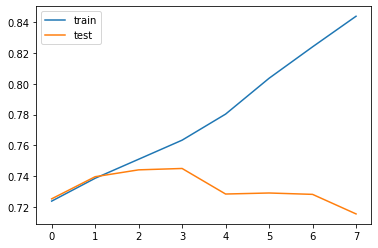

In [55]:
%%time
from matplotlib import pyplot
train_acc = model.evaluate(X_train, y_train, verbose=0)
test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc[1], test_acc[1]))
# plot training history
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [56]:
memory_usage()

,Size
data2,804.57MB
_11,773.15MB
_12,773.15MB
_5,717.27KB
y,350.24KB
y_train,280.22KB
train,280.22KB
predictions,76.02KB
_41,70.13KB
_,70.13KB


## Model 2

In [57]:
import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow.keras.regularizers import l2

# defining the architecture of this connected neural network

def build_fc_model():    
    '''defining the model using the Sequential class'''
    fc_model = tf.keras.Sequential([
      # First define a input layer
      tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
      # Defining the activation function for the first fully connected (Dense) layer      
      tf.keras.layers.Dense(100, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.01)),      
      # Defining the activation function for the second fully connected (Dense) layer      
      tf.keras.layers.Dense(100, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.01)),     
      # Defining the activation function for the third fully connected (Dense) layer      
      tf.keras.layers.Dense(100, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.01)),   
      # Defining the second Dense layer to output the classification probabilities
      tf.keras.layers.Dense(1, activation=tf.nn.sigmoid, activity_regularizer=tf.keras.regularizers.L2(0.01))       
    ])
    return fc_model

model2 = build_fc_model()
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100)               502000    
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 522,301
Trainable params: 522,301
Non-trainable params: 0
_________________________________________________________________


In [58]:
learning_rate = 0.01

model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [61]:
%%time
BATCH_SIZE = 64
EPOCHS = 5
history2 = model2.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=BATCH_SIZE, epochs=EPOCHS,verbose=1)

Epoch 1/5
561/561 [==============================] - 15s 27ms/step - loss: 0.5890 - accuracy: 0.7253 - val_loss: 0.5889 - val_accuracy: 0.7252
Epoch 2/5
561/561 [==============================] - 15s 26ms/step - loss: 0.5890 - accuracy: 0.7253 - val_loss: 0.5889 - val_accuracy: 0.7252
Epoch 3/5
561/561 [==============================] - 15s 27ms/step - loss: 0.5889 - accuracy: 0.7253 - val_loss: 0.5890 - val_accuracy: 0.7252
Epoch 4/5
561/561 [==============================] - 16s 27ms/step - loss: 0.5890 - accuracy: 0.7253 - val_loss: 0.5890 - val_accuracy: 0.7252
Epoch 5/5
561/561 [==============================] - 16s 28ms/step - loss: 0.5890 - accuracy: 0.7253 - val_loss: 0.5889 - val_accuracy: 0.7252
CPU times: user 1min 51s, sys: 31.3 s, total: 2min 22s
Wall time: 1min 19s


In [ ]:
loss, accuracy = model2.evaluate(X_train, y_train)
print("\nLoss: %.2f, Accuracy: %.2f%%" % (loss, accuracy*100))

In [ ]:
import numpy
probabilities = model2.predict(X_test)
predictions = [float(numpy.round(x)) for x in probabilities]
accuracy = numpy.mean(predictions == y_test)
print("Prediction Accuracy: %.2f%%" % (accuracy*100))

In [ ]:
# create BASIC model (train data high accuracy 98% but test only 75%)

#model = Sequential()
#model.add(Dense(60, input_dim=10000, activation='relu'))
#model.add(Dense(1, activation='sigmoid'))
# Compile model
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
outfile = '/Users/wailunchung/Documents/GitHub/Capstone_data/my_model'
model.save(outfile)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

In [ ]:
y_train_predclass = model.predict(X_train,batch_size=batch_size)
y_test_predclass = model.predict(X_test,batch_size=batch_size)



In [ ]:
from sklearn.metrics import accuracy_score,classification_report

print("nnDeep Neural Network - Train accuracy:"),(round(accuracy_score( y_train, y_train_predclass),3))
print("nDeep Neural Network - Test accuracy:"),(round(accuracy_score( y_test,y_test_predclass),3))
print("nDeep Neural Network - Train Classification Report")
print(classification_report(y_train,y_train_predclass))
print("nDeep Neural Network - Test Classification Report")
print(classification_report(y_test,y_test_predclass))



In [ ]:
y_train_predclass

In [ ]:
outfile = '/content/drive/My Drive/Colab Notebooks/my_model'
model.save(outfile)